In [1]:
import pandas as pd
import datetime as dt
import numpy as np
import scipy.optimize

from sublimpy import tidy


import altair as alt
alt.data_transformers.enable('json') 
import matplotlib.pyplot as plt

# Inputs

In [2]:
start_date = '20221130'
end_date = '20230509'
sos_download_dir = '/data2/elilouis/sublimationofsnow/sosnoqc'

In [3]:
try:
    tidy_df_5Min = pd.read_parquet(f"../sos/tidy_df_30Min_{start_date}_{end_date}_noplanar_fit.parquet")
except FileNotFoundError:
    print("No file such file exists for these dates.")
tidy_df_5Min['time'] = pd.to_datetime(tidy_df_5Min['time'])

# M.O.S.T. Solutions

## Extract variables, make necessary conversions, and create measurement height variable

In [4]:
# EXTRACT VARIABLES
VARIABLES = [
    ## Input Variables
    'spd_3m_c',
    'Tpot_3m_c',
    'Tsurfpot_rad_c',
    'airdensity_3m_c',
    'mixingratio_3m_c',
    'Tsurfmixingratio_rad_c',
    'T_3m_c',
    ## Measurement Variables
    'w_h2o__3m_c',
    'w_tc__3m_c',
    'u*_3m_c',
    'Ri_3m_c',
    ## Input Variables for Turbpy
    'Tsurf_rad_d',
    'P_10m_c',
]
print([ v for v in tidy_df_5Min.variable.unique() if v in VARIABLES ])

# CREATE DATAFRAME
variables_df = tidy_df_5Min[tidy_df_5Min.variable.isin(VARIABLES)].pivot_table(
    values = 'value',
    index = 'time',
    columns='variable'
).reset_index()

# MAKE CONVERSIONS
# convert from ˚C to K
variables_df['T_3m_c'] = variables_df['T_3m_c'] + 273.15
variables_df['Tpot_3m_c'] = variables_df['Tpot_3m_c'] + 273.15
variables_df['Tsurfpot_rad_c'] = variables_df['Tsurfpot_rad_c'] + 273.15
variables_df['Tsurf_rad_d'] = variables_df['Tsurf_rad_d']  + 273.15
# convert from g/g to g/kg
variables_df['mixingratio_3m_c'] = variables_df['mixingratio_3m_c']*1000
variables_df['Tsurfmixingratio_rad_c'] = variables_df['Tsurfmixingratio_rad_c']*1000

# CREATE MEASUREMENT HEIGHT VARIABLES
variables_df['measurement_height'] = 3
variables_df['measurement_height'] = 3
variables_df['measurement_height'] = 3

['airdensity_3m_c', 'Tsurfmixingratio_rad_c', 'mixingratio_3m_c', 'Tpot_3m_c', 'P_10m_c', 'Ri_3m_c', 'u*_3m_c', 'Tsurfpot_rad_c', 'Tsurf_rad_d', 'T_3m_c', 'w_h2o__3m_c', 'w_tc__3m_c', 'spd_3m_c']


## Use MOST solver class

In [5]:
from most import MOST, StabilityFunctionBrutsaert1982
my_most = MOST(
    StabilityFunctionBrutsaert1982()
)
L_solutions, u_friction_solutions, H_solutions, E_solutions = my_most.solve(
    variables_df['spd_3m_c'],
    variables_df['Tpot_3m_c'],
    variables_df['Tsurfpot_rad_c'],
    variables_df['airdensity_3m_c'],
    variables_df['mixingratio_3m_c'],
    variables_df['Tsurfmixingratio_rad_c'],
    variables_df['T_3m_c'],
    variables_df['measurement_height']
)

variables_df['L_solution'] = L_solutions
variables_df['u_friction_solution'] = u_friction_solutions
variables_df['H_solution'] = H_solutions
variables_df['E_solution'] = E_solutions


## Plot results

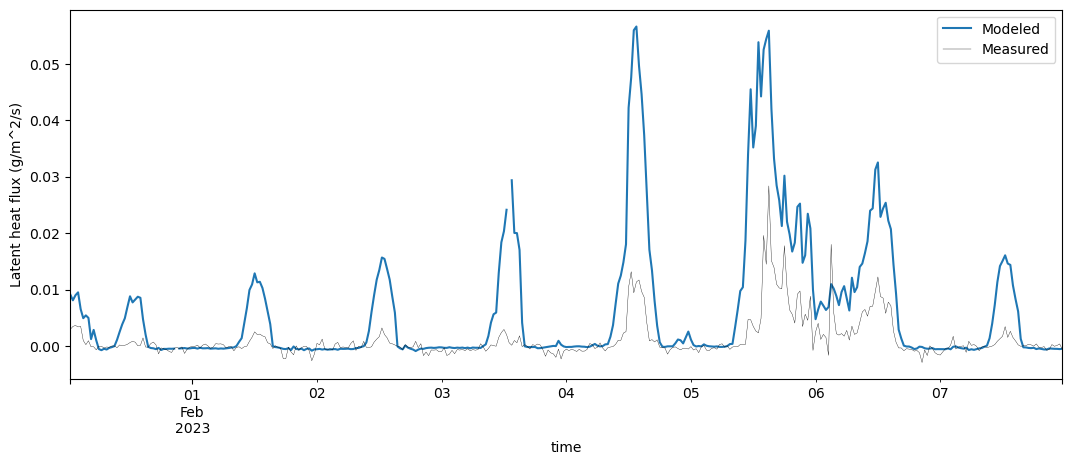

In [6]:
plt.figure(figsize=(2*6.4, 4.8))
src = variables_df[(variables_df.time > "2023-01-31") & (variables_df.time < "2023-02-08")]
src.plot(x='time', y='E_solution', label='Modeled', ax = plt.gca())
src.plot(x='time', y='w_h2o__3m_c', label='Measured', color='black', linewidth=0.25, ax = plt.gca())
# plt.ylim(-0.05, 0.05)
plt.ylabel("Latent heat flux (g/m^2/s)")
plt.legend()

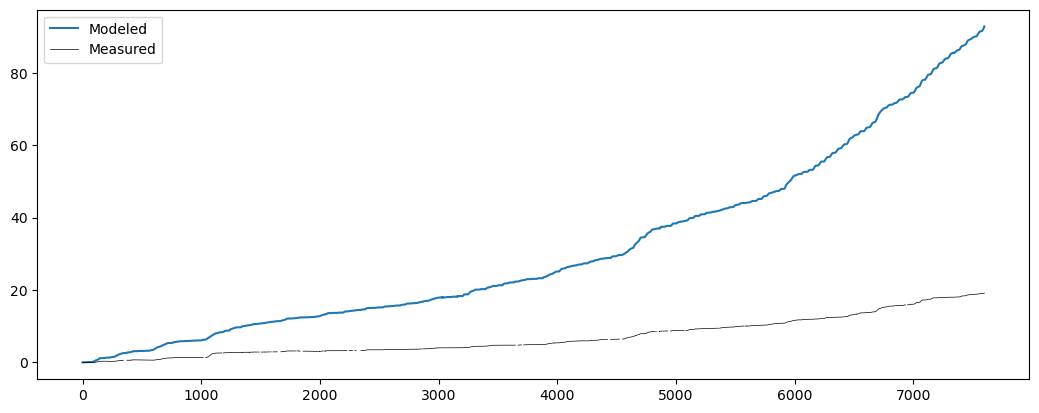

In [7]:
plt.figure(figsize=(12.8, 4.8))
variables_df['E_solution'].cumsum().plot(label='Modeled')
variables_df['w_h2o__3m_c'].cumsum().plot(label='Measured', color='black', linewidth=0.5)
plt.legend()

In [8]:
variables_df['mixingratio_grad'] = (variables_df['mixingratio_3m_c'] - variables_df['Tsurfmixingratio_rad_c']) / 3

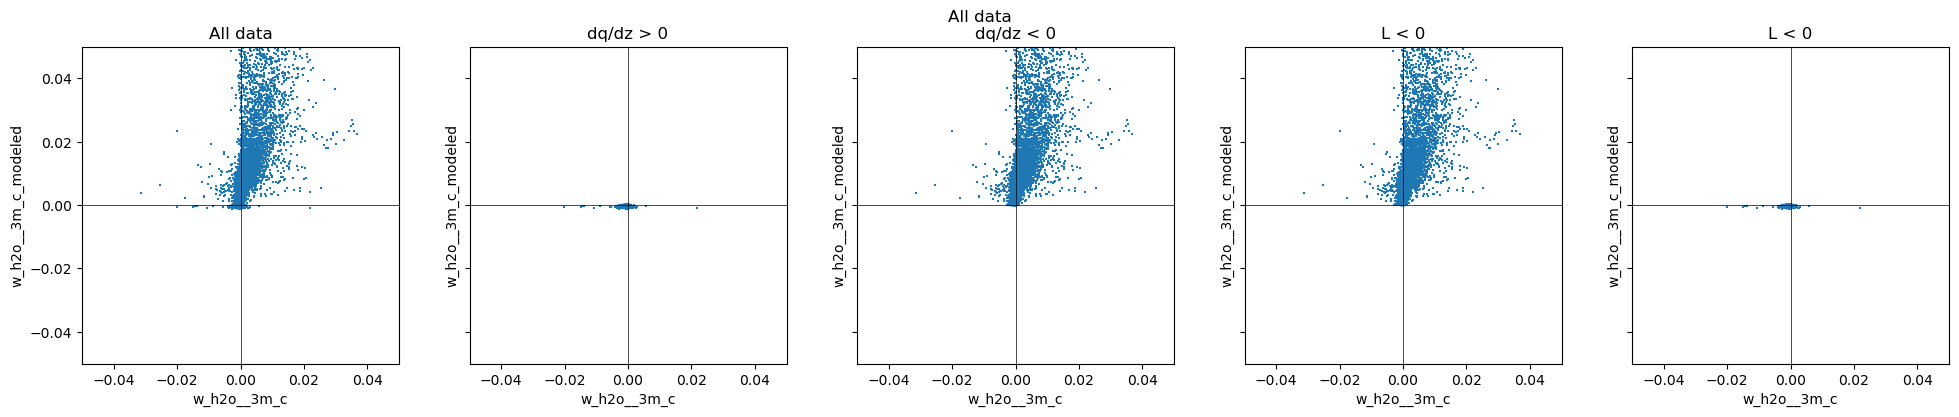

In [9]:
fig, axes = plt.subplots(1,5, figsize=(20,4), sharex=True, sharey=True)

# all data
axes[0].set_title("All data")
axes[0].scatter(variables_df['w_h2o__3m_c'], variables_df['E_solution'], s=0.6, marker='+')

# dq/dz > 0 (expected downward motion of water vapor)
axes[1].set_title("dq/dz > 0")
src = variables_df.query("mixingratio_grad > 0")
axes[1].scatter(src['w_h2o__3m_c'], src['E_solution'], s=0.6, marker='+')

# dq/dz < 0 (expected upward motion of water vapor)
axes[2].set_title("dq/dz < 0")
src = variables_df.query("mixingratio_grad < 0")
axes[2].scatter(src['w_h2o__3m_c'], src['E_solution'], s=0.6, marker='+')

# L < 0
axes[3].set_title("L < 0")
src = variables_df.query("L_solution < 0")
axes[3].scatter(src['w_h2o__3m_c'], src['E_solution'], s=0.6, marker='+')

# L > 0
axes[4].set_title("L < 0")
src = variables_df.query("L_solution > 0")
axes[4].scatter(src['w_h2o__3m_c'], src['E_solution'], s=0.6, marker='+')

for ax in axes:
    ax.set_xlabel('w_h2o__3m_c')
    ax.set_ylabel('w_h2o__3m_c_modeled')
    ax.axhline(0, color='k', linewidth=0.5)
    ax.axvline(0, color='k', linewidth=0.5)
    ax.set_xlim(-0.05, 0.05)
    ax.set_ylim(-0.05, 0.05)
    ax.set_aspect('equal')
plt.suptitle("All data")
plt.tight_layout()

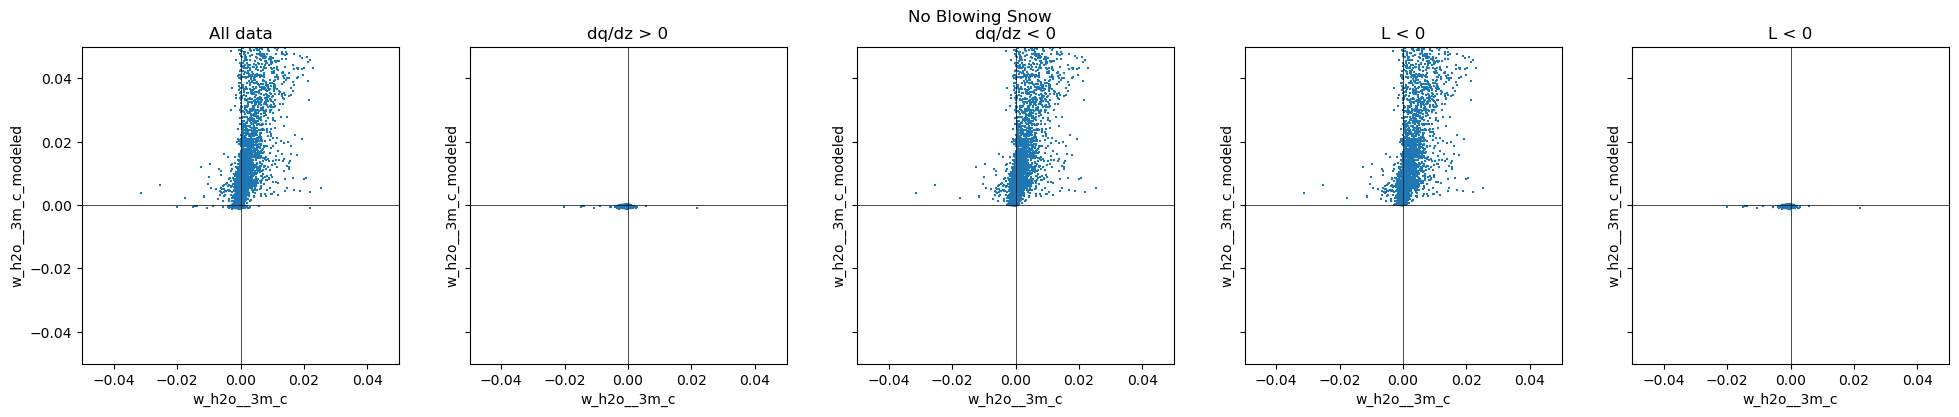

In [10]:
no_bs_times = tidy_df_5Min.query("variable == 'SF_avg_1m_ue'").query("value == 0").time

variables_df_src = variables_df[variables_df.time.isin(no_bs_times)]

fig, axes = plt.subplots(1,5, figsize=(20,4), sharex=True, sharey=True)

# all data
axes[0].set_title("All data")
axes[0].scatter(variables_df_src['w_h2o__3m_c'], variables_df_src['E_solution'], s=0.6, marker='+')

# dq/dz > 0 (expected downward motion of water vapor)
axes[1].set_title("dq/dz > 0")
src = variables_df_src.query("mixingratio_grad > 0")
axes[1].scatter(src['w_h2o__3m_c'], src['E_solution'], s=0.6, marker='+')

# dq/dz < 0 (expected upward motion of water vapor)
axes[2].set_title("dq/dz < 0")
src = variables_df_src.query("mixingratio_grad < 0")
axes[2].scatter(src['w_h2o__3m_c'], src['E_solution'], s=0.6, marker='+')

# L < 0
axes[3].set_title("L < 0")
src = variables_df_src.query("L_solution < 0")
axes[3].scatter(src['w_h2o__3m_c'], src['E_solution'], s=0.6, marker='+')

# L > 0
axes[4].set_title("L < 0")
src = variables_df_src.query("L_solution > 0")
axes[4].scatter(src['w_h2o__3m_c'], src['E_solution'], s=0.6, marker='+')

for ax in axes:
    ax.set_xlabel('w_h2o__3m_c')
    ax.set_ylabel('w_h2o__3m_c_modeled')
    ax.axhline(0, color='k', linewidth=0.5)
    ax.axvline(0, color='k', linewidth=0.5)
    ax.set_xlim(-0.05, 0.05)
    ax.set_ylim(-0.05, 0.05)
    ax.set_aspect('equal')
plt.suptitle("No Blowing Snow")
plt.tight_layout()

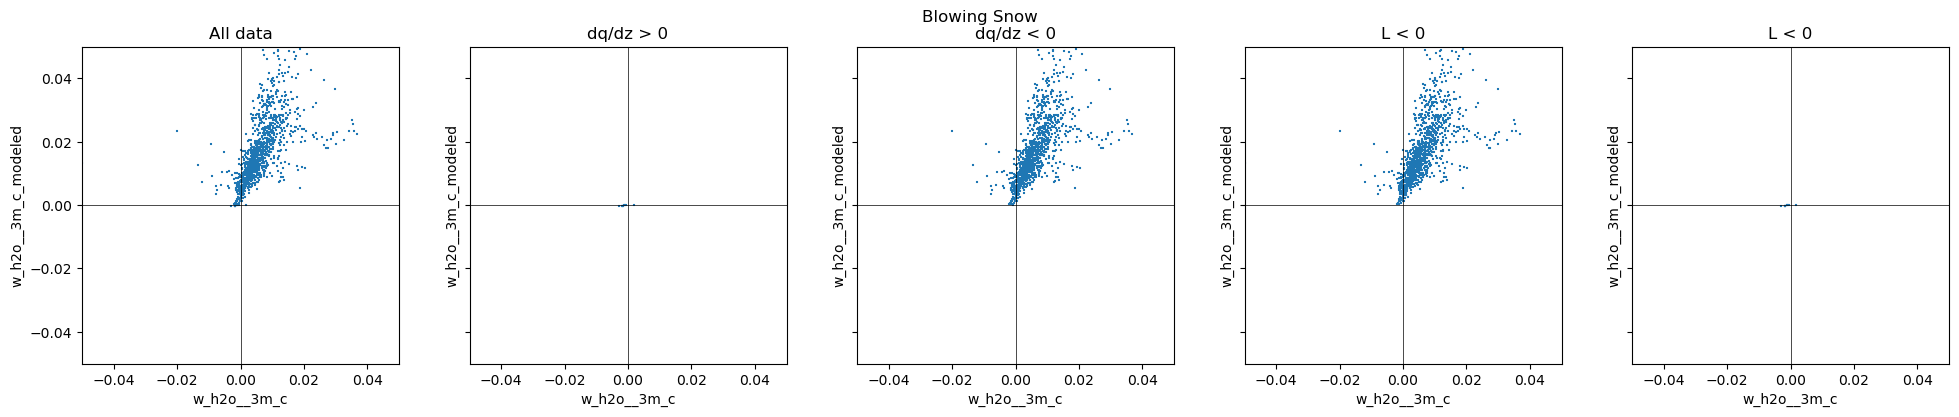

In [11]:
bs_times = tidy_df_5Min.query("variable == 'SF_avg_1m_ue'").query("value > 0").time

variables_df_src = variables_df[variables_df.time.isin(bs_times)]

fig, axes = plt.subplots(1,5, figsize=(20,4), sharex=True, sharey=True)

# all data
axes[0].set_title("All data")
axes[0].scatter(variables_df_src['w_h2o__3m_c'], variables_df_src['E_solution'], s=0.6, marker='+')

# dq/dz > 0 (expected downward motion of water vapor)
axes[1].set_title("dq/dz > 0")
src = variables_df_src.query("mixingratio_grad > 0")
axes[1].scatter(src['w_h2o__3m_c'], src['E_solution'], s=0.6, marker='+')

# dq/dz < 0 (expected upward motion of water vapor)
axes[2].set_title("dq/dz < 0")
src = variables_df_src.query("mixingratio_grad < 0")
axes[2].scatter(src['w_h2o__3m_c'], src['E_solution'], s=0.6, marker='+')

# L < 0
axes[3].set_title("L < 0")
src = variables_df_src.query("L_solution < 0")
axes[3].scatter(src['w_h2o__3m_c'], src['E_solution'], s=0.6, marker='+')

# L > 0
axes[4].set_title("L < 0")
src = variables_df_src.query("L_solution > 0")
axes[4].scatter(src['w_h2o__3m_c'], src['E_solution'], s=0.6, marker='+')

for ax in axes:
    ax.set_xlabel('w_h2o__3m_c')
    ax.set_ylabel('w_h2o__3m_c_modeled')
    ax.axhline(0, color='k', linewidth=0.5)
    ax.axvline(0, color='k', linewidth=0.5)
    ax.set_xlim(-0.05, 0.05)
    ax.set_ylim(-0.05, 0.05)
    ax.set_aspect('equal')
plt.suptitle("Blowing Snow")
plt.tight_layout()

# Use TurbPy

In [12]:
from metpy.units import units
import turbpy
import json
import copy

## Get TurbPy parameter schemes

This code for instantiating the TurbPy schemes was copied from the Turbpy example notebook  

https://github.com/klapo/turbpy/blob/master/TF.turbpyDemonstration.ipynb

In [13]:
scheme_dict_1 = {
    'MO (Holtslag/de Bruin)': {
            'stability_method': 'monin_obukhov',
            'monin_obukhov': {
                'gradient_function': 'holtslag_debruin'
            }
        },
    
}
scheme_dict_2 = {
    'MO (Webb)': {
            'stability_method': 'monin_obukhov',
            'monin_obukhov': {
                'gradient_function': 'webb'
            },
            'stability_params': {
                'webb': 5.2
            }
    },
    'MO (Webb NoahMP)': {
            'stability_method': 'monin_obukhov',
            'monin_obukhov': {
                'gradient_function': 'webb_noahmp'
            },
            'stability_params': {
                'webb': 5.2
            }
    },
    'MO (Marks-Dozier)': {
            'stability_method': 'monin_obukhov',
            'monin_obukhov': {
                'gradient_function': 'marks_dozier'
            },
            'stability_params': {
                'marks_dozier': 5.2
            }
    }
}

## Retrieve our input measurements and convert to units required by TurbPy

In [14]:
from metpy.calc import specific_humidity_from_mixing_ratio
import xarray as xr
import pint_xarray

In [15]:
SNOW_SURFACE_ROUGHNESS = 1e-4
height = 3
snowDepth = 0
fillna_method='ffill'

# collect inputs
sfcTemp = variables_df['Tsurf_rad_d']
airTemp = variables_df['T_3m_c']
windspd = variables_df['spd_3m_c']
airPressure = (variables_df['P_10m_c'].values * units.millibar).to(units.pascal).magnitude

# the turbpy.vapPress function requires specific humidity in units of g/g
specific_humidity_g_per_g = specific_humidity_from_mixing_ratio(
    xr.DataArray(variables_df['mixingratio_3m_c'])*units('g/kg')
).pint.to('g/g').values

airVaporPress = turbpy.vapPress(
    specific_humidity_g_per_g,
    airPressure
)

# requires temp in units ˚C
(sfcVaporPress, _) = turbpy.satVapPress(sfcTemp - 273.15)

In [16]:
variables_df[['Tsurf_rad_d',
'T_3m_c',
'spd_3m_c',
'P_10m_c',
'mixingratio_3m_c',]]

variable,Tsurf_rad_d,T_3m_c,spd_3m_c,P_10m_c,mixingratio_3m_c
0,257.076847,260.352508,3.323426,713.159607,1.308300
1,254.252201,260.099139,4.556745,713.428101,0.995834
2,253.104264,259.767198,3.731591,714.011922,0.960208
3,250.783456,258.161803,1.838974,714.681264,1.018992
4,249.214067,256.820924,1.354227,715.163198,1.058835
...,...,...,...,...,...
7594,277.832551,284.321712,3.279272,719.592316,2.849836
7595,277.770560,284.559379,4.236264,719.428986,2.896958
7596,277.713243,284.165380,2.612355,719.380747,3.095123
7597,277.589692,284.578926,3.576606,719.295563,2.999904


## Run the calculations

In [17]:

## Calculate stability
# Initialzie dictionaries for containing output
stability_correction = {}
conductance_sensible = {}
conductance_latent = {}
sensible_heat = {}
latent_heat = {}
zeta = {}

for scheme in [scheme_dict_1, scheme_dict_2]:
    for stab in scheme.keys():
        stability_correction[stab] = np.zeros_like(sfcTemp)
        conductance_sensible[stab] = np.zeros_like(sfcTemp)
        conductance_latent[stab] = np.zeros_like(sfcTemp)
        sensible_heat[stab] = np.zeros_like(sfcTemp)
        latent_heat[stab] = np.zeros_like(sfcTemp)
        zeta[stab] = np.zeros_like(sfcTemp)

    ## Calculate stability
    for stab in scheme.keys():
        for n, (tair, vpair, tsfc, vpsfc, u, airP) in enumerate(zip(
            airTemp, airVaporPress, sfcTemp, sfcVaporPress, windspd, airPressure
        )):
            if any(np.isnan([tair, vpair, tsfc, vpsfc, u, airP])):
                stability_correction[stab][n] = np.nan
                conductance_sensible[stab][n] = np.nan
                conductance_latent[stab][n] = np.nan
                sensible_heat[stab][n] = np.nan
                latent_heat[stab][n] = np.nan
                zeta[stab][n] = np.nan
            else:
                (
                    conductance_sensible[stab][n], 
                    conductance_latent[stab][n], 
                    sensible_heat[stab][n],
                    latent_heat[stab][n],
                    stab_output,
                    p_test
                ) = turbpy.turbFluxes(tair, airP,
                                                        vpair, u, tsfc,
                                                        vpsfc, snowDepth,
                                                        height, param_dict=scheme[stab],
                                                        z0Ground=SNOW_SURFACE_ROUGHNESS, groundSnowFraction=1)
                # Get the Zeta value from the stability parameters dictionary
                if scheme[stab]['stability_method'] != 'monin_obukhov':
                    stability_correction[stab][n] = stab_output['stabilityCorrection']
                    # SHOULD I JUST BE ASSIGNING NAN HERE?
                    zeta[stab][n] = stab_output['zeta']
                else:
                    stability_correction[stab][n] = np.nan
                    zeta[stab][n] = stab_output['zeta']

## Create dataframe with the Turbpy results, our iterative solution results, and our measurement dataset

In [18]:
for key in stability_correction.keys():
    variables_df[f'latent_heat_flux {key}'] = -latent_heat[key]/2838
    variables_df[f'sensible_heat_flux {key}'] = -sensible_heat[key]
    variables_df[f'obukhov_length {key}'] = 3 / zeta[key]

In [19]:
variables_df

variable,time,P_10m_c,Ri_3m_c,T_3m_c,Tpot_3m_c,Tsurf_rad_d,Tsurfmixingratio_rad_c,Tsurfpot_rad_c,airdensity_3m_c,mixingratio_3m_c,...,obukhov_length MO (Holtslag/de Bruin),latent_heat_flux MO (Webb),sensible_heat_flux MO (Webb),obukhov_length MO (Webb),latent_heat_flux MO (Webb NoahMP),sensible_heat_flux MO (Webb NoahMP),obukhov_length MO (Webb NoahMP),latent_heat_flux MO (Marks-Dozier),sensible_heat_flux MO (Marks-Dozier),obukhov_length MO (Marks-Dozier)
0,2022-11-29 17:00:00,713.159607,0.119395,260.352508,286.680558,257.076847,1.536413,283.042939,0.954360,1.308300,...,5.376135,1.086580e-03,-1.678002e+01,5.279150,1.110654e-03,-1.715145e+01,5.324172,0.001087,-16.780020,5.279150
1,2022-11-29 17:30:00,713.428101,0.116963,260.099139,286.370790,254.252201,1.206803,279.902879,0.955830,0.995834,...,6.179387,1.381839e-03,-4.050347e+01,6.076256,1.407813e-03,-4.126447e+01,6.129529,0.001382,-40.503466,6.076256
2,2022-11-29 18:00:00,714.011922,0.309685,259.767198,285.938493,253.104264,1.092322,278.574006,0.957856,0.960208,...,3.024821,4.638329e-04,-2.538325e+01,2.806904,4.830006e-04,-2.643115e+01,3.000000,0.000486,-26.607164,2.857300
3,2022-11-29 18:30:00,714.681264,2.038709,258.161803,284.095353,250.783456,0.892740,275.945832,0.964693,1.018992,...,0.356033,-7.178197e-17,-3.915070e-12,0.006845,-7.178197e-17,-3.915070e-12,3.000000,-0.000292,-16.031875,0.560825
4,2022-11-29 19:00:00,715.163198,0.933350,256.820924,282.565278,249.214067,0.775638,274.166134,0.970349,1.058835,...,0.137744,-1.132641e-16,-2.972360e-12,0.011882,-1.132641e-16,-2.972360e-12,3.000000,-0.000478,-12.549125,0.278193
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7594,2023-05-09 15:30:00,719.592316,0.903728,284.321712,312.271602,277.832551,7.451935,305.111431,0.880965,2.849836,...,2.688042,1.408298e-02,-2.028266e+01,2.465947,1.474054e-02,-2.122817e+01,3.000000,0.016325,-23.509134,2.607264
7595,2023-05-09 16:00:00,719.428986,0.099363,284.559379,312.552903,277.770560,7.421094,305.063127,0.880004,2.896958,...,5.150907,2.667675e-02,-4.085869e+01,4.949762,2.750596e-02,-4.212789e+01,5.086265,0.026677,-40.858688,4.949762
7596,2023-05-09 16:30:00,719.380747,0.223501,284.165380,312.126115,277.713243,7.391507,305.006018,0.881061,3.095123,...,1.401913,4.592875e-03,-7.069357e+00,1.081957,5.042455e-03,-7.758188e+00,3.000000,0.012522,-19.230832,1.602691
7597,2023-05-09 17:00:00,719.295563,0.233426,284.578926,312.590933,277.589692,7.328030,304.880642,0.879727,2.999904,...,3.071813,1.596984e-02,-2.633250e+01,2.861871,1.673627e-02,-2.759450e+01,3.000000,0.016513,-27.227764,2.897497


## Plot results

In [20]:
method_names = list(scheme_dict_1.keys()) + list(scheme_dict_2.keys())
method_names

['MO (Holtslag/de Bruin)',
 'MO (Webb)',
 'MO (Webb NoahMP)',
 'MO (Marks-Dozier)']

In [21]:
import itertools
from sklearn.metrics import r2_score

In [22]:
for (x,y) in list(itertools.combinations(method_names, 2)):
    print(x)
    print(y)
    print(r2_score(variables_df.dropna()[f'latent_heat_flux {x}'],    variables_df.dropna()[f'latent_heat_flux {y}']))
    print()

MO (Holtslag/de Bruin)
MO (Webb)
0.9974246607789008

MO (Holtslag/de Bruin)
MO (Webb NoahMP)
0.9980487546639407

MO (Holtslag/de Bruin)
MO (Marks-Dozier)
0.9962720135748587

MO (Webb)
MO (Webb NoahMP)
0.999874643717009

MO (Webb)
MO (Marks-Dozier)
0.9905806160673432

MO (Webb NoahMP)
MO (Marks-Dozier)
0.9910959850568407



In [23]:

src = variables_df[(variables_df.time > '2022-12-24') & (variables_df.time < '2022-12-26')]
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(src[['w_h2o__3m_c', 'E_solution']].dropna()['w_h2o__3m_c'], src[['w_h2o__3m_c', 'E_solution']].dropna()[f'E_solution']) 
print("Our solution")
print(r_value**2)
print(np.mean(src['E_solution'] - src['w_h2o__3m_c']))
print()

for x in method_names:
    print(x)
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(src[['w_h2o__3m_c', f'latent_heat_flux {x}']].dropna()['w_h2o__3m_c'], src[['w_h2o__3m_c', f'latent_heat_flux {x}']].dropna()[f'latent_heat_flux {x}']) 
    print(r_value**2)
    print(np.mean(src[f'latent_heat_flux {x}'] - src['w_h2o__3m_c']))
    print()

Our solution
0.7208865494670318
0.009777396125737213

MO (Holtslag/de Bruin)
0.7258593090331069
0.008028274422742815

MO (Webb)
0.7271039733035153
0.008049351588796955

MO (Webb NoahMP)
0.7267950438674501
0.008068902368816851

MO (Marks-Dozier)
0.7232723266760749
0.007923074707497887



In [24]:
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(src.dropna()['w_h2o__3m_c'], src.dropna()[f'E_solution'])
r_value**2, p_value

(0.7208865494670318, 1.948979158789818e-24)

In [25]:
r_value**2, p_value

(0.7208865494670318, 1.948979158789818e-24)

In [26]:
variables_df['zeta_solution'] = 3 / variables_df['L_solution']
variables_df['zeta MO (Marks-Dozier)'] = 3 / variables_df['obukhov_length MO (Marks-Dozier)']

In [27]:
def stability_regime_from_zeta(zeta):
    if np.isnan(zeta):
        return np.nan
    if zeta < -0.01:
        return "unstable"
    elif zeta > -0.01 and zeta < 0.01:
        return "neutral"
    elif zeta > 0.01 and zeta <= 1:
        return "stable"
    elif zeta > 1:
        return "very stable"
    else:
        print("WTF?")
        return np.nan
variables_df['stability regime'] = variables_df['zeta_solution'].apply(stability_regime_from_zeta)
variables_df['stability regime (turbpy)'] = variables_df['zeta MO (Marks-Dozier)'].apply(stability_regime_from_zeta)

In [28]:
variables_df['end_time'] = variables_df['time'] + dt.timedelta(minutes=30)
unstable_times = variables_df[variables_df['stability regime'] == 'unstable']
neutral_times = variables_df[variables_df['stability regime'] == 'neutral']
stable_times = variables_df[variables_df['stability regime'] == 'stable']
v_stable_times = variables_df[variables_df['stability regime'] == 'very stable']

(-50.0, 50.0)

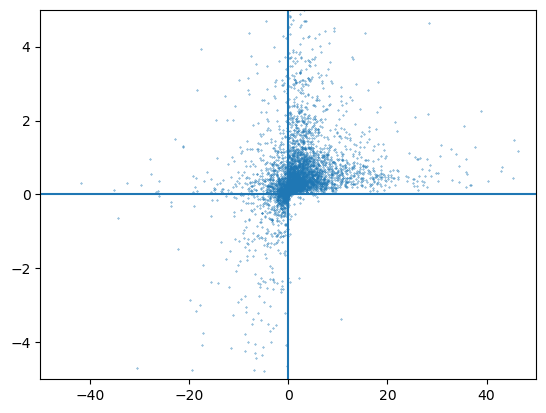

In [29]:
plt.scatter(variables_df['zeta MO (Marks-Dozier)'], variables_df['Ri_3m_c'], s=0.1),
plt.axhline(0)
plt.axvline(0)
plt.ylim(-5, 5)
plt.xlim(-50, 50)

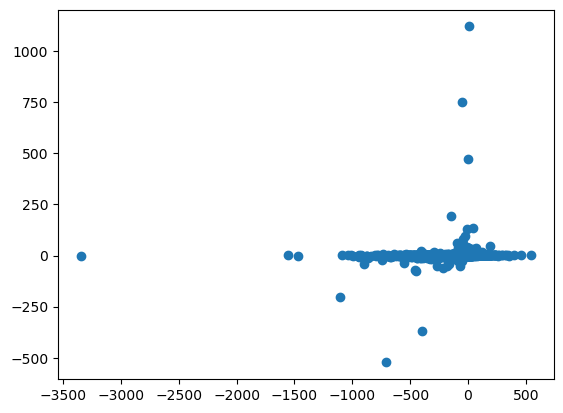

In [30]:
plt.scatter(variables_df['zeta_solution'], variables_df['Ri_3m_c'])

Text(0, 0.5, 'Latent heat fluxes (g/m^2/s)')

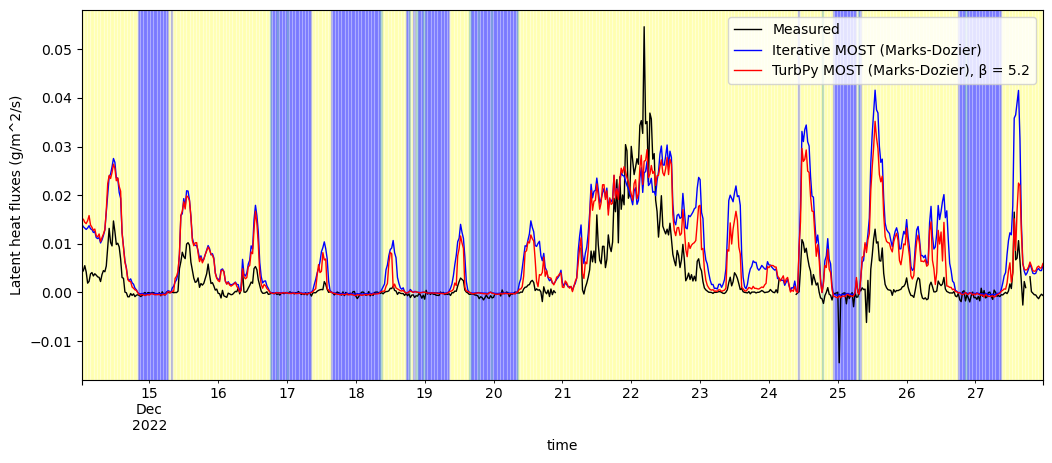

In [31]:
src = variables_df[(variables_df.time > '2022-12-14') & (variables_df.time < '2022-12-28')]
# src = variables_df
plt.figure(figsize=(12.4, 4.8))
src.plot(x = 'time', y = 'w_h2o__3m_c',                         label = 'Measured',                             color='black',  linewidth=1.0, ax = plt.gca())
src.plot(x = 'time', y = 'E_solution',                          label = 'Iterative MOST (Marks-Dozier)',        color='blue',   linewidth=1.0, ax = plt.gca())
src.plot(x = 'time', y = 'latent_heat_flux MO (Marks-Dozier)',  label = 'TurbPy MOST (Marks-Dozier), β = 5.2',  color='red',  linewidth=1.0, ax = plt.gca())
# src.plot(x = 'time', y = 'latent_heat_flux MO (Webb NoahMP)',   label = 'TurbPy MOST (Webb NoahMP), β = 5.2',   color='red',    linewidth=1.0, ax = plt.gca())
# plt.gca().axhline(0)

for i, row in variables_df.iterrows():
    if row['stability regime'] == 'unstable':
        plt.gca().axvspan(row['time'], row['end_time'], color='yellow', alpha=0.1, label='unstable')
    if row['stability regime'] == 'neutral':
        plt.gca().axvspan(row['time'], row['end_time'], color='grey', alpha=0.2, label='neutral')
    if row['stability regime'] == 'stable':
        plt.gca().axvspan(row['time'], row['end_time'], color='teal', alpha=0.2, label='stable')
    if row['stability regime'] == 'very stable':
        plt.gca().axvspan(row['time'], row['end_time'], color='blue', alpha=0.2, label='very stable')


plt.ylabel("Latent heat fluxes (g/m^2/s)")

Text(0, 0.5, 'Latent heat fluxes (g/m^2/s)')

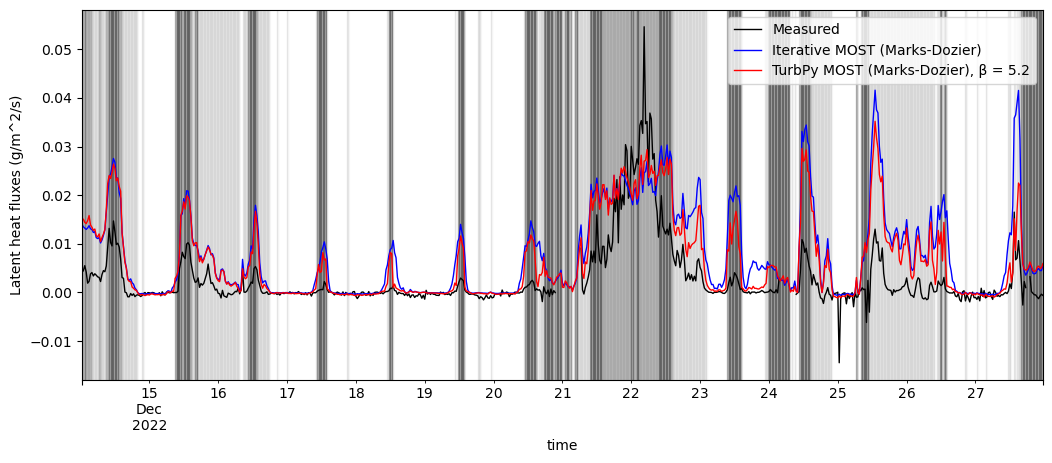

In [32]:
src = variables_df[(variables_df.time > '2022-12-14') & (variables_df.time < '2022-12-28')]
# src = variables_df
plt.figure(figsize=(12.4, 4.8))
src.plot(x = 'time', y = 'w_h2o__3m_c',                         label = 'Measured',                             color='black',  linewidth=1.0, ax = plt.gca())
src.plot(x = 'time', y = 'E_solution',                          label = 'Iterative MOST (Marks-Dozier)',        color='blue',   linewidth=1.0, ax = plt.gca())
src.plot(x = 'time', y = 'latent_heat_flux MO (Marks-Dozier)',  label = 'TurbPy MOST (Marks-Dozier), β = 5.2',  color='red',  linewidth=1.0, ax = plt.gca())
# src.plot(x = 'time', y = 'latent_heat_flux MO (Webb NoahMP)',   label = 'TurbPy MOST (Webb NoahMP), β = 5.2',   color='red',    linewidth=1.0, ax = plt.gca())
# plt.gca().axhline(0)

for i, row in variables_df.iterrows():
    if row['stability regime (turbpy)'] == 'unstable':
        plt.gca().axvspan(row['time'], row['end_time'], color='black', alpha=0.25, label='unstable')
    if row['stability regime (turbpy)'] == 'neutral':
        plt.gca().axvspan(row['time'], row['end_time'], color='darkgrey', alpha=0.75, label='neutral')
    if row['stability regime (turbpy)'] == 'stable':
        plt.gca().axvspan(row['time'], row['end_time'], color='lightgrey', alpha=0.5, label='stable')
    if row['stability regime (turbpy)'] == 'very stable':
        plt.gca().axvspan(row['time'], row['end_time'], color='white', alpha=0.5, label='very stable')


plt.ylabel("Latent heat fluxes (g/m^2/s)")

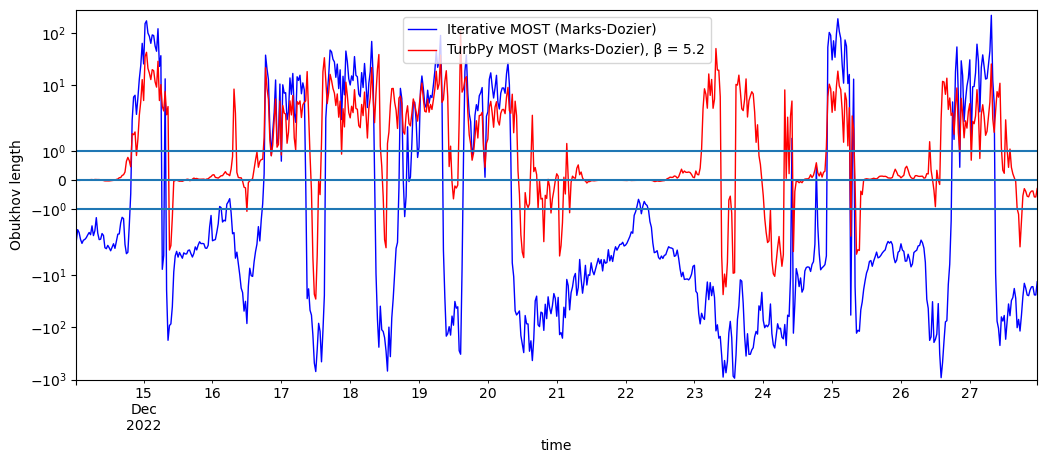

In [33]:
src = variables_df[(variables_df.time > '2022-12-14') & (variables_df.time < '2022-12-28')]



# src = variables_df
plt.figure(figsize=(12.4, 4.8))
src.plot(x = 'time', y = 'zeta_solution',                          label = 'Iterative MOST (Marks-Dozier)',        color='blue',   linewidth=1.0, ax = plt.gca())
src.plot(x = 'time', y = 'zeta MO (Marks-Dozier)',  label = 'TurbPy MOST (Marks-Dozier), β = 5.2',  color='red',  linewidth=1.0, ax = plt.gca())
# src.plot(x = 'time', y = 'latent_heat_flux MO (Webb NoahMP)',   label = 'TurbPy MOST (Webb NoahMP), β = 5.2',   color='red',    linewidth=1.0, ax = plt.gca())
# plt.gca().axhline(0)
plt.ylabel("Obukhov length")
# plt.ylim(-250,250)
plt.yscale('symlog')

plt.axhline(0)
plt.axhline(1)
plt.axhline(-1)